# Part 1 - Localization from one camera

### Importing libraries

In [1]:
from helpers.setup import parse_config_file
import sys
import numpy as np
from scipy import io
from scipy.spatial.distance import cdist

import cv2 
from cv2 import DMatch
import matplotlib.pyplot as plt

### Getting features from video

This function implements the SIFT algorithm to find keypoints of the image

In [2]:
def get_features(vid_capture, frames_to_process):
    features = np.zeros((1, frames_to_process), dtype=object)
    frames = []
    keypoints_array = []
    current_frame = 0 
    while(vid_capture.isOpened()):
        # vid_capture.read() methods returns a tuple, first element is a bool 
        # and the second is frame
        for _ in range(100):
            ret, frame = vid_capture.read()
            
        sift = cv2.SIFT_create(nfeatures=64)
        if ret == True:
            # getting keypoints and descriptor
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
            # Equalize the distribution of the image
            frame_equalize = cv2.equalizeHist(frame_gray)
            keypoints, descriptor = sift.detectAndCompute(frame_equalize, None)
            keypoints_array.append(keypoints)

            # getting the location of each keypoint
            location = []
            for keypoint in keypoints:
                location.append(keypoint.pt)
            location = np.array(location)
            ## (x, y, d)
            concatenation = np.insert(np.transpose(descriptor), 0, location[:, 0], axis=0)
            concatenation = np.insert(concatenation, 1, location[:, 1], axis=0)
            #print(f'concatenation: {np.shape(concatenation)}') 
            features[0, current_frame] = concatenation

            current_frame += 1
            frames.append(frame)
            static_frame = cv2.drawKeypoints(frame, keypoints, None, color=(0, 255, 0))
            cv2.imwrite(f"./debugfiles/keypoints/{config['videos'].split('.mp4')[0].split('/')[1]}_keypoints_frame_{current_frame}.png", static_frame)
            cv2.imshow('Static Keypoints', static_frame)
            
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break

            if current_frame == frames_to_process:
                break
        else:
            break
    # print(features.shape)
    vid_capture.release()
    cv2.destroyAllWindows()
    return features, frames, keypoints_array

### Finding matches from keypoint descriptors from two images

In [3]:
def match_features(features1, features2, matches_size = 100):
    # Euclidean distance
    D = cdist(features1, features2, 'euclidean')
    
    # Sorting distances and finding nearest neighbors
    I = np.argsort(D, axis=1)
    nearest_neighbor = D[np.arange(len(D)), I[:, 0]]
    second_nearest_neighbor = D[np.arange(len(D)), I[:, 1]]
    confidences = nearest_neighbor / second_nearest_neighbor
    
    # Filtering non-zero confidences
    i = np.where(confidences)[0]
    matches = np.column_stack((i, I[i]))
    confidences = 1.0 / confidences[i]
    
    # Sorting by confidence and selecting top 100 matches
    sorted_indices = np.argsort(confidences)[::-1]
    matches = matches[sorted_indices][:matches_size, :]
    confidences = confidences[sorted_indices][:matches_size]

    matches = [DMatch(_queryIdx=int(match[0]), 
                      _trainIdx=int(match[1]), 
                      _distance=float(D[int(match[0]), int(match[1])])) 
                          for match in matches]
    
    return matches, confidences

### Creating homography matrix  from sets of points

From two sets of points this function compute the homography between them

In [4]:
from numpy.linalg import eig

def create_homography_matrix(src_points, dst_points):
    A = []
    b = [] 
    for i in range(len(src_points)):
        x, y = src_points[i]
        u, v = dst_points[i]
        A.append([x, y, 1, 0, 0, 0, -u*x, -u*y])
        A.append([0, 0, 0, x, y, 1, -v*x, -v*y])

        b.append(u)
        b.append(v)
    try:
        A = np.array(A)
        h = np.dot((np.dot(np.linalg.inv(np.dot(A.T,A)),A.T)), b)
        h = np.append(h, 1) 
        h = h.reshape(3,3)    
        return h
    except Exception as e:
        pass

### Homography from features

In [5]:
def homographies_from_features(features, frames_to_process):
    homographies = []
    for i in range(frames_to_process):
        for j in range(i+1, frames_to_process):
            matches, confidences = match_features(np.transpose(features[0, i][2:]), np.transpose(features[0, j][2:]), matches_size=100)

            src_points = []
            dst_points = []

            for match in matches:
                src_points.append(features[0, i][:2, match.queryIdx])
                dst_points.append(features[0, j][:2, match.trainIdx])

            src_points = np.array(src_points)
            dst_points = np.array(dst_points)
                
                
            homography = [i+1, j+1]
            homography_matrix = create_homography_matrix(src_points, dst_points)
            homography.extend(homography_matrix.flatten())
            homographies.append(homography)
            
            matched_img = cv2.drawMatches(frames[i], keypoints_array[i], frames[j], keypoints_array[j], matches, None, flags=2)
            h, w, _ = matched_img.shape
            matched_img = cv2.resize(matched_img, (int(3*w/4), int(3*h/4)), interpolation = cv2.INTER_LINEAR)
            cv2.putText(matched_img, f"{i}, {j}", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            cv2.imwrite(f"./debugfiles/matches/{config['videos'].split('.mp4')[0].split('/')[1]}_matches_frame_{i+1}_{j+1}.png", matched_img)
            cv2.imshow('Matches', matched_img)

            img_i = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
            img_j = cv2.cvtColor(frames[j], cv2.COLOR_BGR2GRAY)

            # Warp img_i to img_j using the computed homography
            img_i_warped = cv2.warpPerspective(img_i, homography_matrix, (img_j.shape[1], img_j.shape[0]))

            # Concatenate the two images side by side for visualization
            concatenated_imgs = np.concatenate((img_j, img_i_warped), axis=1)
            h, w = concatenated_imgs.shape
            concatenated_imgs = cv2.resize(concatenated_imgs, (int(1*w/2), int(1*h/2)), interpolation = cv2.INTER_LINEAR)
            cv2.imwrite(f"./debugfiles/homography/{config['videos'].split('.mp4')[0].split('/')[1]}_homography_frame_{i+1}_{j+1}.png", concatenated_imgs)
            cv2.imshow(f"Homography", concatenated_imgs)
            
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
    cv2.destroyAllWindows()
    return homographies

### Homography from corresponding points (map)

In [6]:
def homographies_from_corresponding_points(pts_in_map_from_config, pts_in_frame_from_config):
    homographies = []
    for i in range(len(pts_in_map_from_config)):
        pts_in_map = np.array(pts_in_map_from_config[i][1:], dtype=float)
        pts_in_map = pts_in_map.reshape(int(len(pts_in_map)/2), 2)
        pts_in_frame = np.array(pts_in_frame_from_config[i][1:], dtype=float)
        pts_in_frame = pts_in_frame.reshape(int(len(pts_in_frame)/2), 2)
        homography = [0, int(pts_in_frame_from_config[i][0])]
        homography.extend(create_homography_matrix(pts_in_frame, pts_in_map).flatten())
        homographies.append(homography)
    return homographies

### `processing_video.py` main

In [7]:
config_path = "./conf_file.cpg"
config = parse_config_file(config_path)

vid_capture = cv2.VideoCapture(config['videos'])
frames_to_process = 5

features, frames, keypoints_array = get_features(vid_capture, frames_to_process)
data={'features': features}
io.savemat(config['keypoints_out'], data)

In [8]:
i = 3
j = 4
matches, confidences = match_features(np.transpose(features[0, i][2:]), np.transpose(features[0, j][2:]), matches_size=32)

src_points = []
dst_points = []

for match in matches:
    src_points.append(features[0, i][:2, match.queryIdx])
    dst_points.append(features[0, j][:2, match.trainIdx])

#src_points = np.array(src_points)
#dst_points = np.array(dst_points)
print(src_points)
print(dst_points)

[array([313.73605, 170.2772 ], dtype=float32), array([290.6755 , 174.68245], dtype=float32), array([342.44778, 212.04826], dtype=float32), array([290.6755 , 174.68245], dtype=float32), array([208.96933, 248.29721], dtype=float32), array([342.44778, 212.04826], dtype=float32), array([ 66.02338, 179.70544], dtype=float32), array([289.1819, 323.2119], dtype=float32), array([367.4637, 371.6545], dtype=float32), array([208.96933, 248.29721], dtype=float32), array([225.94565, 123.61295], dtype=float32), array([455.23096, 210.69144], dtype=float32), array([225.94565, 123.61295], dtype=float32), array([350.23416, 375.1535 ], dtype=float32), array([153.93042,  87.12107], dtype=float32), array([ 56.000904, 181.97778 ], dtype=float32), array([123.304405, 184.01128 ], dtype=float32), array([197.1002 , 150.34721], dtype=float32), array([101.43623, 343.39957], dtype=float32), array([249.64835, 424.58838], dtype=float32), array([176.08061,  73.11254], dtype=float32), array([343.15698, 197.01515], dty

### `compute_transform.py` main

In [9]:
config_path = "./conf_file.cpg"
config = parse_config_file(config_path)

if config['transforms'][0][0] == 'homography':
    if config['transforms'][0][1] == 'all':
        homographies = homographies_from_features(features, frames_to_process)
    elif config['transforms'][0][1] == 'map':
        if len(config['pts_in_map']) != len(config['pts_in_frame']):
            print("Different amount of pts_in_map and pts_in_frame defined inside the config file")
            sys.exit(1)
        homographies = homographies_from_corresponding_points(config['pts_in_map'], config['pts_in_frame'])
        print(homographies)
    data={'transforms': np.array(homographies).transpose()}
    io.savemat(config['transforms_out'], data)
else:
    print("The only acceptable type is \"homography\"")

[[0, 1, 0.7416253448496072, -0.41551474159862684, 149.4533268325182, -0.02891102574295744, 0.7942320760638439, 20.68017959222137, -0.0003496189081216027, -0.00014775617743278808, 1.0], [0, 3, 0.9022473691999517, -0.20469653603719606, 74.05058242833019, -0.008003055058000277, 0.9434759995157461, 4.402507854212546, -0.00015888611867714115, 2.2734159758208618e-05, 1.0]]


### Implementing RANSAC to remove outliers
WORKING...

In [10]:
def ransac_homography_custom(src_points, dst_points, i, j, iterations=100, threshold=5.0):
    src_points = np.array(src_points)
    dst_points = np.array(dst_points)
    best_homography = None
    max_inliers = 0
    n_points = src_points.shape[0]
    best_projects = None

    for _ in range(iterations):
        # Randomly select 4 points for homography computation
        indices = np.random.choice(n_points, 4, replace=False)
        src_sample = src_points[indices]
        dst_sample = dst_points[indices]

        
        # Estimate homography using these points
        try:
            H = create_homography_matrix(src_sample, dst_sample)
            # Project src_points using the estimated homography
            ones = np.ones((n_points, 1))
            homogeneous_src_points = np.hstack([src_points, ones])
            projected_points = (H @ homogeneous_src_points.T).T
            projected_points = projected_points[:, :2] / projected_points[:, [2]]

            # Calculate distances between projected and actual destination points
            distances = np.sqrt(np.sum((projected_points - dst_points) ** 2, axis=1))

            # Count inliers
            inliers_count = np.sum(distances < threshold)

            # Update the best homography matrix if more inliers are found
            if inliers_count > max_inliers:
                best_homography = H.copy()
                max_inliers = inliers_count
                best_projects = projected_points
        except:
            continue

        # img_i = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
        # img_j = cv2.cvtColor(frames[j], cv2.COLOR_BGR2GRAY)

        # # Warp img_i to img_j using the computed homography
        # img_i_warped = cv2.warpPerspective(img_i, H, (img_j.shape[1], img_j.shape[0]))

        # # Concatenate the two images side by side for visualization
        # concatenated_imgs = np.concatenate((img_j, img_i_warped), axis=1)
        # h, w = concatenated_imgs.shape
        # concatenated_imgs = cv2.resize(concatenated_imgs, (int(1*w/2), int(1*h/2)), interpolation = cv2.INTER_LINEAR)
        # cv2.imshow(f"Homography RANSAC", concatenated_imgs)

    # Re-estimate homography using all inliers if a model was found
    if best_homography is not None:
        inliers = np.sqrt(np.sum((best_projects - dst_points) ** 2, axis=1)) < threshold
        best_homography = create_homography_matrix(src_points[inliers], dst_points[inliers])

    return np.array(best_homography), inliers

In [11]:
def homographies_from_features(features, frames_to_process, debug_mode=True):
    homographies = []
    for i in range(frames_to_process):
        for j in range(i+1, frames_to_process):
            matches, confidences = match_features(np.transpose(features[0, i][2:]), np.transpose(features[0, j][2:]), matches_size=32)

            src_points = []
            dst_points = []

            for match in matches:
                src_points.append(features[0, i][:2, match.queryIdx])
                dst_points.append(features[0, j][:2, match.trainIdx])

            src_points = np.array(src_points)
            dst_points = np.array(dst_points)
                
            homography = [i+1, j+1]
            homography_matrix, _ = ransac_homography_custom(src_points, dst_points, i, j, 5000)
            Homography_cv, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)
            
            homography.extend(homography_matrix.flatten())
            homographies.append(homography)
            
            if debug_mode == True:
                matched_img = cv2.drawMatches(frames[i], keypoints_array[i], frames[j], keypoints_array[j], matches, None, flags=2)
                h, w, _ = matched_img.shape
                matched_img = cv2.resize(matched_img, (int(3*w/4), int(3*h/4)), interpolation = cv2.INTER_LINEAR)
                cv2.putText(matched_img, f"{i}, {j}", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
                cv2.imwrite(f"./debugfiles/matches/{config['videos'].split('.mp4')[0].split('/')[1]}_matches_frame_{i+1}_{j+1}_R.png", matched_img)
                cv2.imshow('Matches', matched_img)

                img_i = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
                img_j = cv2.cvtColor(frames[j], cv2.COLOR_BGR2GRAY)

                # Warp img_i to img_j using the computed homography
                img_i_warped = cv2.warpPerspective(img_i, homography_matrix, (img_j.shape[1], img_j.shape[0]))
                img_open_cv = cv2.warpPerspective(img_i, Homography_cv, (img_j.shape[1], img_j.shape[0]))

                cv2.putText(img_i, "Original image", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
                cv2.putText(img_i_warped, "Custom H", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
                cv2.putText(img_open_cv, "Open CV H", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

                # Concatenate the two images side by side for visualization
                concatenated_imgs = np.concatenate((img_i, img_i_warped, img_open_cv), axis=1)
                h, w = concatenated_imgs.shape
                concatenated_imgs = cv2.resize(concatenated_imgs, (int(1*w/2), int(1*h/2)), interpolation = cv2.INTER_LINEAR)
                cv2.imwrite(f"./debugfiles/homography/{config['videos'].split('.mp4')[0].split('/')[1]}_homography_frame_{i+1}_{j+1}_R.png", concatenated_imgs)
                cv2.imshow(f"Homography", concatenated_imgs)
                
                if cv2.waitKey(60) & 0xFF == ord('q'):
                    break
    cv2.destroyAllWindows()
    return homographies

In [12]:
def homographies_from_map(features, frame_to_process, pts_in_map, pts_in_frame, debug_mode=False):
    homographies = np.array(homographies_from_corresponding_points(pts_in_map, pts_in_frame))
    indexes_frame = np.array(homographies)[:, 1]
    for i in range(frame_to_process):
        current_frame = i + 1
        if current_frame in indexes_frame:
            continue
        else:
            # get nearest frame 
            difference_array = np.absolute(indexes_frame-current_frame)
            near_value = int(indexes_frame[difference_array.argmin()]) - 1
            
            # compute homography between nearest frame and i 
            matches, confidences = match_features(np.transpose(features[0, i][2:]), np.transpose(features[0, near_value][2:]), matches_size=32)

            src_points = []
            dst_points = []

            for match in matches:
                src_points.append(features[0, i][:2, match.queryIdx])
                dst_points.append(features[0, near_value][:2, match.trainIdx])

            src_points = np.array(src_points)
            dst_points = np.array(dst_points)

            homography_i_to_near_value, _ = ransac_homography_custom(src_points, dst_points, i, near_value, iterations=5000)

            # compute compose homography
            homography_near_value_to_map = homographies[np.where(indexes_frame == near_value + 1)[0][0], 2:].reshape(3,3)
            homography = [0, current_frame]
            homography.extend(np.array(homography_near_value_to_map @ homography_i_to_near_value).flatten())
            homographies = np.vstack((homographies, homography))
    return homographies

### `compute_transform.py` main now with RANSAC

WORKING...

In [13]:
config_path = "./conf_file.cpg"
config = parse_config_file(config_path)

if config['transforms'][0][0] == 'homography':
    if config['transforms'][0][1] == 'all':
        homographies = homographies_from_features( features, frames_to_process)
    elif config['transforms'][0][1] == 'map':
        if len(config['pts_in_map']) != len(config['pts_in_frame']):
            print("Different amount of pts_in_map and pts_in_frame defined inside the config file")
            sys.exit(1)
        homographies = homographies_from_map(features, frames_to_process, config['pts_in_map'], config['pts_in_frame'])
    data={'transforms': np.array(homographies).transpose()}
    io.savemat(config['transforms_out'], data)
else:
    print("The only acceptable type is \"homography\"")

### Testing Homography

[[ 9.03241271e-01 -1.54956996e-01  6.49150892e+01]
 [-1.87824290e-02  9.82137603e-01  1.79400226e+00]
 [-2.11256323e-04  1.45025404e-04  1.00000000e+00]]
[[ 9.46504350e-01 -1.48414378e-01  6.23709402e+01]
 [-4.04007851e-03  1.01524419e+00 -2.87677911e+00]
 [-1.42532362e-04  2.00615660e-04  1.00000000e+00]]


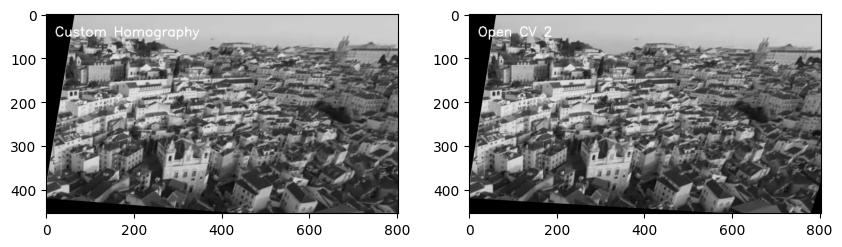

In [14]:
i,j = 1,3

matches, confidences = match_features(np.transpose(features[0, i][2:]), np.transpose(features[0, j][2:]), matches_size=32)

src_points = []
dst_points = []

for match in matches:
    src_points.append(features[0, i][:2, match.queryIdx])
    dst_points.append(features[0, j][:2, match.trainIdx])

src_points = np.array(src_points)
dst_points = np.array(dst_points)
                
                
homography_custom, mask = ransac_homography_custom(src_points, dst_points, i, j, 5000)
#homography_cv1, mask = cv2.findHomography(np.array(src_points), np.array(dst_points), cv2.RANSAC, 5.0)
homography_cv2, mask = cv2.findHomography(np.array(src_points), np.array(dst_points), cv2.RANSAC, 5.0)

print(homography_custom)
print(homography_cv2)


img_i = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
img_j = cv2.cvtColor(frames[j], cv2.COLOR_BGR2GRAY)

img_i_warped = cv2.warpPerspective(img_i, homography_custom, (img_j.shape[1], img_j.shape[0]))
img_open_cv = cv2.warpPerspective(img_i, homography_cv2, (img_j.shape[1], img_j.shape[0]))

cv2.putText(img_i, "Original image", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
cv2.putText(img_i_warped, "Custom Homography", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
cv2.putText(img_open_cv, "Open CV 2", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

concatenated_imgs = np.concatenate((img_i, img_i_warped, img_open_cv), axis=1)
h, w = concatenated_imgs.shape
concatenated_imgs = cv2.resize(concatenated_imgs, (int(1*w/2), int(1*h/2)), interpolation = cv2.INTER_LINEAR)
cv2.imshow(f"Homography", concatenated_imgs)

if cv2.waitKey(10000):
    cv2.destroyAllWindows()

fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    
ax[0].imshow(cv2.cvtColor(img_i_warped, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(img_open_cv, cv2.COLOR_BGR2RGB))

### Homography map

In [15]:
homographies_all = np.array(homographies_from_features(features, frames_to_process, debug_mode=False))
homographies_map = homographies_from_map(features, frames_to_process-1, config['pts_in_map'], config['pts_in_frame'])

homography cv: 
 [[ 8.12580972e-01 -4.00612667e-01  1.50255433e+02]
 [ 2.45304103e-02  8.91964236e-01  1.15467739e+00]
 [-2.00359986e-04  9.36174323e-06  1.00000000e+00]]
homography all: 
 [[ 7.65713162e-01 -3.95799856e-01  1.52508037e+02]
 [-9.28745082e-03  8.54874510e-01  1.25984664e+01]
 [-2.98837495e-04 -7.76210356e-07  1.00000000e+00]] 
homography map: 
 [[ 7.41625345e-01 -4.15514742e-01  1.49453327e+02]
 [-2.89110257e-02  7.94232076e-01  2.06801796e+01]
 [-3.49618908e-04 -1.47756177e-04  1.00000000e+00]]
homography cv: 
 [[ 8.45510173e-01 -2.34665148e-01  9.21617150e+01]
 [-2.25103258e-02  8.74621102e-01  1.37304554e+01]
 [-2.75940673e-04 -5.24340033e-06  1.00000000e+00]]
homography all: 
 [[ 8.61793422e-01 -2.22314510e-01  9.38120678e+01]
 [-2.36325695e-02  9.79068363e-01  1.98013880e+00]
 [-3.12134282e-04  2.27167807e-04  1.00000000e+00]] 
homography map: 
 [[ 7.91478081e-01 -3.31067513e-01  1.19454192e+02]
 [-2.17640521e-02  8.12866107e-01  1.97626150e+01]
 [-2.66935273e-04 -2

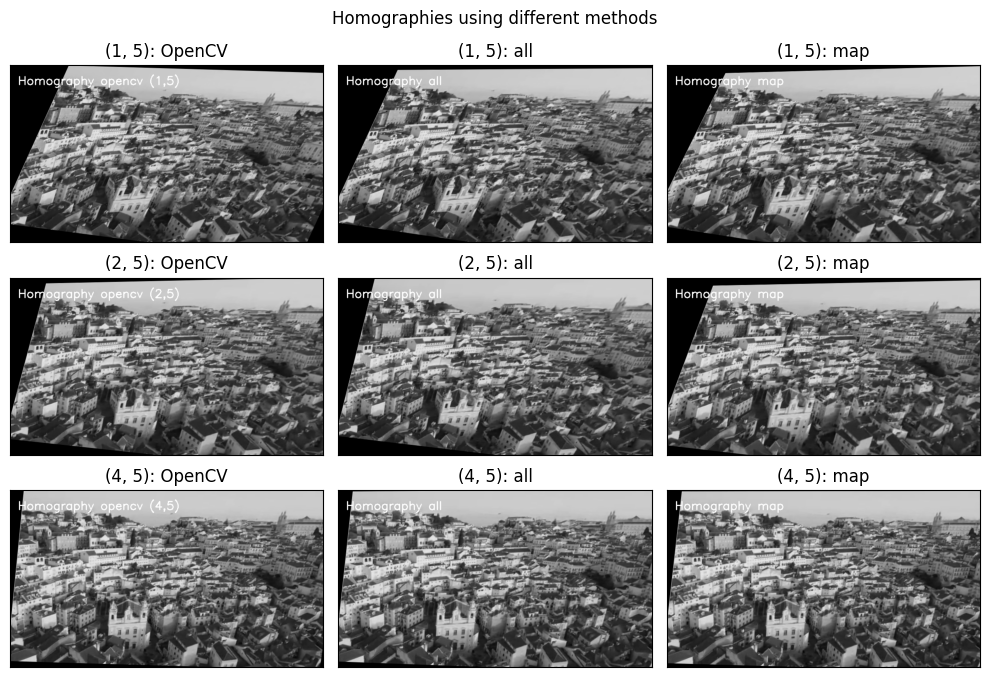

In [24]:
j = 4 # map 

fig, ax = plt.subplots(3, 3, figsize=(10, 7))
plt.suptitle('Homographies using different methods')

for i in range(frames_to_process-1):
    # get indexes
    index_all = np.where(np.all(homographies_all[:, 0:2] == [i+1, j+1], axis=1))[0][0]
    index_map = np.where(np.all(homographies_map[:, 0:2] == [0, i+1], axis=1))[0][0]


    # get correspond homography
    #homographies_all = homographies_all[index_all, 2:].reshape(3, 3)
    #homographies_map = homographies_map[index_map, 2:].reshape(3, 3)
    matches, confidences = match_features(np.transpose(features[0, i][2:]), np.transpose(features[0, j][2:]), matches_size=32)

    src_points = []
    dst_points = []

    for match in matches:
        src_points.append(features[0, i][:2, match.queryIdx])
        dst_points.append(features[0, j][:2, match.trainIdx])

    homography_cv, mark = cv2.findHomography(np.array(src_points), np.array(dst_points), cv2.RANSAC, 5.0)
    
    # get frames
    img_i = cv2.cvtColor(frames[i], cv2.COLOR_BGR2GRAY)
    img_j = cv2.cvtColor(frames[j], cv2.COLOR_BGR2GRAY)

    print(f'homography cv: \n {homography_cv}')
    print(f'homography all: \n {homographies_all[index_all, 2:].reshape(3, 3)} ')
    print(f'homography map: \n {homographies_map[index_map, 2:].reshape(3, 3)}')
    # transform image
    img_open_cv = cv2.warpPerspective(img_i, homography_cv, (img_j.shape[1], img_j.shape[0]))
    img_all = cv2.warpPerspective(img_i, homographies_all[index_all, 2:].reshape(3, 3), (img_j.shape[1], img_j.shape[0]))
    img_map = cv2.warpPerspective(img_i, homographies_map[index_map, 2:].reshape(3, 3), (img_j.shape[1], img_j.shape[0]))

    # show images
    cv2.putText(img_open_cv, f"Homography opencv ({i+1},{j+1})", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(img_all, "Homography all", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(img_map, "Homography map", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    concatenated_imgs = np.concatenate((img_open_cv, img_all, img_map), axis=1)
    h, w = concatenated_imgs.shape
    concatenated_imgs = cv2.resize(concatenated_imgs, (int(1*w/2), int(1*h/2)), interpolation = cv2.INTER_LINEAR)
    cv2.imshow(f"Homography", concatenated_imgs)
    cv2.imwrite(f"./debugfiles/homography/homography_open_cv_map_all_{i}_{j}.png", concatenated_imgs)

    if cv2.waitKey(1000):
        cv2.destroyAllWindows()

    if i + 1 == 1 or i + 1 == 2:
        ax[i][0].imshow(cv2.cvtColor(img_open_cv, cv2.COLOR_BGR2RGB))
        ax[i][0].set_title(f'({i+1}, {j+1}): OpenCV')
        ax[i][0].set_xticks([])
        ax[i][0].set_yticks([])

        ax[i][1].imshow(cv2.cvtColor(img_all, cv2.COLOR_BGR2RGB))
        ax[i][1].set_title(f'({i+1}, {j+1}): all')
        ax[i][1].set_xticks([])
        ax[i][1].set_yticks([])

        ax[i][2].imshow(cv2.cvtColor(img_map, cv2.COLOR_BGR2RGB))
        ax[i][2].set_title(f'({i+1}, {j+1}): map')
        ax[i][2].set_xticks([])
        ax[i][2].set_yticks([])

    elif i + 1 == 4:
        ax[2][0].imshow(cv2.cvtColor(img_open_cv, cv2.COLOR_BGR2RGB))
        ax[2][0].set_title(f'({i+1}, {j+1}): OpenCV')
        ax[2][0].set_xticks([])
        ax[2][0].set_yticks([])

        ax[2][1].imshow(cv2.cvtColor(img_all, cv2.COLOR_BGR2RGB))
        ax[2][1].set_title(f'({i+1}, {j+1}): all')
        ax[2][1].set_xticks([])
        ax[2][1].set_yticks([])

        ax[2][2].imshow(cv2.cvtColor(img_map, cv2.COLOR_BGR2RGB))
        ax[2][2].set_title(f'({i+1}, {j+1}): map')
        ax[2][2].set_xticks([])
        ax[2][2].set_yticks([])

plt.tight_layout()
plt.show()